In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
try:
    df = pd.read_csv("HomeLight_Marketing_Ad_Group_Data.csv")  # Replace "your_data.csv" with your file name
except FileNotFoundError:
    print("Error: File not found. Please make sure the file exists and the path is correct.")
    exit()

### Exploratory Data Analysis

In [4]:
df.head()

,lead_created_pst,campaign_name,ad_group,cost,expected_revenue,clicks,conversions,contact_rate,referral_rate,ref_ms _rate
0,5/31/24,Campaign ABC,AG 1,0.00,0.0,0,0,NaN,NaN,NaN
1,5/31/24,Campaign ABC,AG2,0.00,0.0,0,0,NaN,NaN,NaN
2,5/31/24,Campaign ABC,AG 3,0.00,0.0,0,0,NaN,NaN,NaN
3,5/31/24,Campaign ABC,AG 4,21.93,0.0,3,0,NaN,NaN,NaN
4,5/31/24,Campaign ABC,AG 5,7.03,0.0,1,0,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lead_created_pst  7801 non-null   object 
 1   campaign_name     7801 non-null   object 
 2   ad_group          7801 non-null   object 
 3   cost              7801 non-null   float64
 4   expected_revenue  7801 non-null   float64
 5   clicks            7801 non-null   int64  
 6   conversions       7801 non-null   int64  
 7   contact_rate      2585 non-null   float64
 8   referral_rate     2585 non-null   float64
 9   ref_ms _rate      1763 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 609.6+ KB


In [6]:
df['ad_group'].value_counts()

ad_group
AG 6     153
AG 1     152
AG 4     152
AG 7     152
AG 8     152
        ... 
AG 31      6
AG 68      1
AG 63      1
AG 62      1
AG 72      1
Name: count, Length: 73, dtype: int64

### Data Transformation

In [7]:
df['ad_group'] = df['ad_group'].str.replace(r'\s+', '', regex=True).str.upper()

In [8]:
df['lead_created_pst'] = pd.to_datetime(df['lead_created_pst'])

C:\Users\julio\AppData\Local\Temp\ipykernel_18244\2276323663.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['lead_created_pst'] = pd.to_datetime(df['lead_created_pst'])


In [9]:
for col in ['contact_rate', 'referral_rate', 'ref_ms _rate']:
    df[col] = df.groupby('ad_group')[col].transform(lambda x: x.fillna(x.mean()))

#### Creating new variables

In [10]:
df['actual_revenue'] = df['expected_revenue'] * (1 + (df['conversions'] > 0) * pd.Series(np.random.rand(len(df))))
df['click_to_conversion_rate'] = df['conversions'] / df['clicks']
df['click_to_conversion_rate'] = df['click_to_conversion_rate'].fillna(df['click_to_conversion_rate'].mean())
df['roas'] = np.where(df['cost'] == 0, 0, df['actual_revenue'] / df['cost'])
df['cost_per_conversion'] = np.where(df['conversions'] == 0, 0, df['cost'] / df['conversions'])
df['cost_per_click'] = np.where(df['clicks'] == 0, 0, df['cost'] / df['clicks'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   lead_created_pst          7801 non-null   datetime64[ns]
 1   campaign_name             7801 non-null   object        
 2   ad_group                  7801 non-null   object        
 3   cost                      7801 non-null   float64       
 4   expected_revenue          7801 non-null   float64       
 5   clicks                    7801 non-null   int64         
 6   conversions               7801 non-null   int64         
 7   contact_rate              7418 non-null   float64       
 8   referral_rate             7418 non-null   float64       
 9   ref_ms _rate              7107 non-null   float64       
 10  actual_revenue            7801 non-null   float64       
 11  click_to_conversion_rate  7801 non-null   float64       
 12  roas                

#### Data Visualization

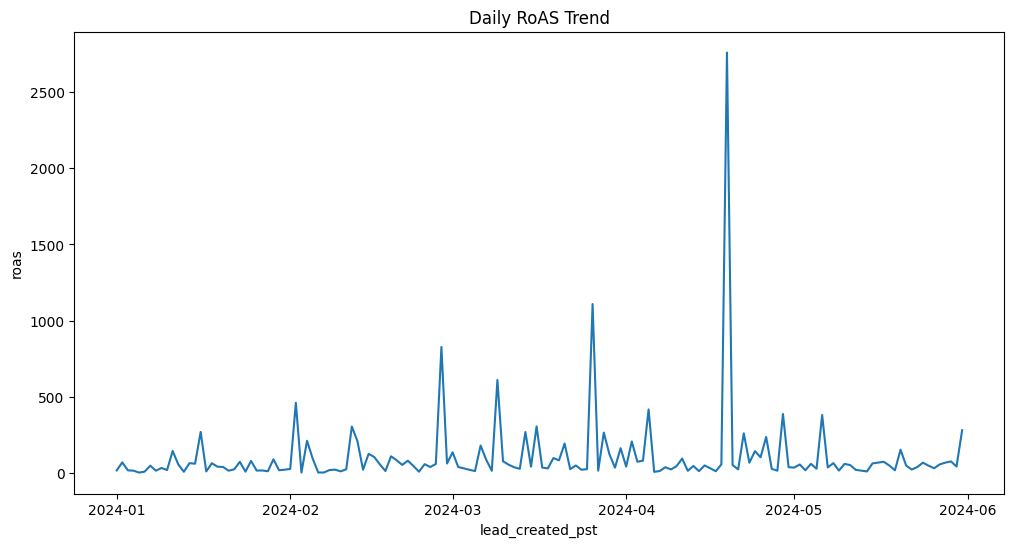

In [12]:
df_daily = df.groupby('lead_created_pst')[['roas', 'cost', 'actual_revenue', 'clicks', 'conversions']].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_created_pst', y='roas', data=df_daily)
plt.title('Daily RoAS Trend')
plt.show()

In [24]:
top_70_ad_groups = df.groupby('ad_group')['conversions'].sum().nlargest(70).index
df_top_70 = df[df['ad_group'].isin(top_70_ad_groups)]

summary_table = df_top_70.groupby('ad_group').agg({
    'cost': 'sum',
    'actual_revenue': 'sum',
    'roas': 'mean',
    'clicks': 'sum',
    'conversions': 'sum',
    'contact_rate': 'mean',
    'referral_rate': 'mean',
    'ref_ms _rate': 'mean',
    'click_to_conversion_rate': 'mean',
    'cost_per_conversion': 'mean',
    'cost_per_click': 'mean'
})

# Style the table
styled_table = summary_table.style.format({
    'cost': "${:,.2f}",
    'actual_revenue': "${:,.2f}",
    'roas': "{:.2f}",
    'contact_rate': "{:.2%}",
    'referral_rate': "{:.2%}",
    'ref_ms _rate': "{:.2%}",
    'click_to_conversion_rate': "{:.2%}",
    'cost_per_conversion': "${:,.2f}",
    'cost_per_click': "${:,.2f}"
}).background_gradient(cmap='Blues', subset=['actual_revenue']).highlight_max(subset=['roas'], color='lightgreen')

display(styled_table)


,cost,actual_revenue,roas,clicks,conversions,contact_rate,referral_rate,ref_ms _rate,click_to_conversion_rate,cost_per_conversion,cost_per_click
ad_group,,,,,,,,,,,
AG1,"$1,641.08","$10,001.70",2.52,394,21,65.00%,47.50%,36.36%,6.06%,$3.34,$3.20
AG10,$979.71,"$2,174.57",1.67,236,19,54.76%,69.05%,33.33%,7.17%,$1.58,$2.75
AG11,"$2,497.74","$12,762.91",1.78,575,25,49.11%,36.61%,27.27%,3.90%,$3.28,$3.94
AG12,"$3,400.80","$7,046.82",1.97,760,42,33.94%,31.10%,31.11%,5.04%,$7.83,$4.41
AG13,"$2,503.55",$947.70,0.29,991,35,34.62%,33.33%,20.00%,4.19%,$4.64,$2.51
AG14,"$3,098.82",$490.96,0.12,1827,37,28.52%,28.52%,13.33%,2.02%,$4.43,$1.69
AG15,"$1,657.11","$5,543.23",1.82,487,28,50.00%,54.35%,30.77%,6.22%,$2.46,$2.56
AG16,"$1,105.20","$9,951.44",5.46,216,22,52.50%,62.50%,50.00%,9.78%,$5.38,$4.33
AG17,"$3,473.25","$2,989.76",0.73,1094,65,43.06%,24.03%,30.95%,6.31%,$7.89,$3.31


### Query SQL 

In [27]:
import duckdb
summary_table = summary_table.reset_index()

In [30]:
query = ''' SELECT * FROM summary_table order by cost_per_click DESC

'''

duckdb.sql(query)

┌───────┬──────────┬───────────────────┬────────────────────┬────────────────────┬────────┬─────────────┬─────────────────────┬─────────────────────┬─────────────────────┬──────────────────────────┬─────────────────────┬─────────────────────┐
│ index │ ad_group │       cost        │   actual_revenue   │        roas        │ clicks │ conversions │    contact_rate     │    referral_rate    │    ref_ms _rate     │ click_to_conversion_rate │ cost_per_conversion │   cost_per_click    │
│ int64 │ varchar  │      double       │       double       │       double       │ int64  │    int64    │       double        │       double        │       double        │          double          │       double        │       double        │
├───────┼──────────┼───────────────────┼────────────────────┼────────────────────┼────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────────────┼──────────────────────────┼─────────────────────┼─────────────────────┤
│    17 │ AG25     │      27

In [31]:
query = '''
SELECT 
AVG(cost_per_click)
FROM summary_table

'''

duckdb.sql(query)

┌─────────────────────┐
│ avg(cost_per_click) │
│       double        │
├─────────────────────┤
│  2.5918323618176857 │
└─────────────────────┘

In [32]:
query = '''
SELECT 
AVG(ROAS)
FROM summary_table

'''

duckdb.sql(query)

┌────────────────────┐
│     avg(ROAS)      │
│       double       │
├────────────────────┤
│ 2.7009216127412583 │
└────────────────────┘

In [37]:
query = '''
SELECT
*
FROM summary_table
WHERE ROAS > 0
order by ROAS ASC

LIMIT 10

'''

duckdb.sql(query)

┌───────┬──────────┬─────────────┬────────────────────┬──────────────────────┬────────┬─────────────┬─────────────────────┬─────────────────────┬─────────────────────┬──────────────────────────┬─────────────────────┬────────────────────┐
│ index │ ad_group │    cost     │   actual_revenue   │         roas         │ clicks │ conversions │    contact_rate     │    referral_rate    │    ref_ms _rate     │ click_to_conversion_rate │ cost_per_conversion │   cost_per_click   │
│ int64 │ varchar  │   double    │       double       │        double        │ int64  │    int64    │       double        │       double        │       double        │          double          │       double        │       double       │
├───────┼──────────┼─────────────┼────────────────────┼──────────────────────┼────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────────────┼──────────────────────────┼─────────────────────┼────────────────────┤
│    26 │ AG33     │      179.47 │  25.776321070

#### Creating new Analysis and query

In [66]:
contact_rate_threshold = 0.5 
referral_rate_threshold = 0.4  
ref_ms_rate_threshold = 0.2

In [40]:
ad_group_performance = df.groupby('ad_group').agg({
    'contact_rate': 'mean',
    'referral_rate': 'mean',
    'ref_ms _rate': 'mean',
    'conversions': 'sum'
}).reset_index()

In [42]:
underperforming_ad_groups = ad_group_performance[
    (ad_group_performance['contact_rate'] < contact_rate_threshold) |
    (ad_group_performance['referral_rate'] < referral_rate_threshold) |
    (ad_group_performance['ref_ms _rate'] < ref_ms_rate_threshold) &
    (ad_group_performance['conversions'] > 0)
]


In [48]:
print("Underperforming Ad Groups (Ops Issues):")
print(underperforming_ad_groups[['ad_group', 'contact_rate', 'referral_rate', 'ref_ms _rate']])

Underperforming Ad Groups (Ops Issues):
   ad_group  contact_rate  referral_rate  ref_ms _rate
2      AG11      0.491071       0.366071      0.272727
3      AG12      0.339431       0.310976      0.311111
4      AG13      0.346154       0.333333      0.200000
5      AG14      0.285185       0.285185      0.133333
8      AG17      0.430556       0.240278      0.309524
10     AG19      0.545455       0.636364      0.142857
11      AG2      1.000000       1.000000      0.000000
12     AG20      0.432432       0.445946      0.411765
15     AG23      0.423000       0.255667      0.229167
16     AG24      0.000000       0.000000           NaN
23     AG30      0.416667       0.466667      0.400000
25     AG32      0.833333       0.333333      0.000000
26     AG33      0.000000       0.500000      0.000000
27     AG34      0.454843       0.372042      0.240942
28     AG35      0.412078       0.299603      0.104167
29     AG36      0.477163       0.474597      0.305392
30     AG37      0.487179

In [49]:
df_underperforming_ad_groups = pd.DataFrame(underperforming_ad_groups)

In [63]:
df_underperforming_ad_groups['ref_ms_rate'] = df_underperforming_ad_groups['ref_ms _rate']
df_underperforming_ad_groups['sum_rates'] = df_underperforming_ad_groups['ref_ms_rate'] + df_underperforming_ad_groups['contact_rate'] + df_underperforming_ad_groups['referral_rate']

In [65]:
query = '''
SELECT
ad_group
,contact_rate
,referral_rate
,ref_ms_rate
,sum_rates
FROM df_underperforming_ad_groups
WHERE contact_rate > 0
order by 5 asc

'''

duckdb.sql(query)

┌──────────┬─────────────────────┬─────────────────────┬─────────────────────┬────────────────────┐
│ ad_group │    contact_rate     │    referral_rate    │     ref_ms_rate     │     sum_rates      │
│ varchar  │       double        │       double        │       double        │       double       │
├──────────┼─────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ AG48     │ 0.29411764705882354 │ 0.35294117647058826 │                 0.0 │ 0.6470588235294118 │
│ AG45     │  0.4230769230769231 │  0.2692307692307692 │                 0.0 │ 0.6923076923076923 │
│ AG14     │  0.2851851851777778 │  0.2851851851777778 │ 0.13333333333333333 │ 0.7037037036888889 │
│ AG49     │                 0.4 │                 0.4 │                 0.0 │                0.8 │
│ AG35     │  0.4120783730416666 │      0.299603174625 │  0.1041666666607143 │ 0.8158482143273809 │
│ AG13     │ 0.34615384615384615 │  0.3333333333333333 │                 0.2 │ 0.8794871794871795 │
